In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit

from google.colab import drive
drive.mount('/content/drive')
diabetes_dataset = pd.read_csv('/content/drive/My Drive/diabetic_data.csv')
diabetes_dataset.drop(axis=1, columns=['weight', 'medical_specialty', 'payer_code'], inplace=True)
diabetes_dataset = diabetes_dataset.sort_values(by=['patient_nbr', 'encounter_id'])
# Define the ranges and replacement values
ICD9_mapping = [
    ((1, 139), 'Infectious And Parasitic Diseases'),
    ((140, 239), 'Neoplasms'),
    ((240, 279), 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'),
    ((280, 289), 'Diseases Of The Blood And Blood-Forming Organs'),
    ((290, 319), 'Mental Disorders'),
    ((320, 389), 'Diseases Of The Nervous System And Sense Organs'),
    ((390, 459), 'Diseases Of The Circulatory System'),
    ((460, 519), 'Diseases Of The Respiratory System'),
    ((520, 579), 'Diseases Of The Digestive System'),
    ((580, 629), 'Diseases Of The Genitourinary System'),
    ((630, 679), 'Complications Of Pregnancy, Childbirth, And The Puerperium'),
    ((680, 709), 'Diseases Of The Skin And Subcutaneous Tissue'),
    ((710, 739), 'Diseases Of The Musculoskeletal System And Connective Tissue'),
    ((740, 759), 'Congenital Anomalies'),
    ((760, 779), 'Certain Conditions Originating In The Perinatal Period'),
    ((780, 799), 'Symptoms, Signs, And Ill-Defined Conditions'),
    ((800, 999), 'Injury And Poisoning'),
    ('V', 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'),
    ('E', 'Supplementary Classification Of External Causes Of Injury And Poisoning')
]

# Custom function to replace values based on multiple ranges
def replace_multiple_ranges(x, ranges_and_values):
    for values, new_value in ranges_and_values:
        if type(values) == tuple and x[0] != 'V' and x[0] != 'E' and x != '?':
            if values[0] <= int(float(x)) <= values[1]:
                return new_value
        elif type(values) == str and x[0] == values:
            return new_value
    return x

Mounted at /content/drive


In [2]:
# Apply the custom function to the diagnosis columns
diabetes_dataset['diag_1'] = diabetes_dataset['diag_1'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_2'] = diabetes_dataset['diag_2'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_3'] = diabetes_dataset['diag_3'].apply(replace_multiple_ranges, args=(ICD9_mapping,))

# Replace '?' with 'no record' across diag_2 and diag_3
diabetes_dataset[['diag_2', 'diag_3']] = diabetes_dataset[['diag_2', 'diag_3']].replace('?', 'no record')

# Replace '?' with NaN
diabetes_dataset[['race', 'diag_1']] = diabetes_dataset[['race', 'diag_1']].replace('?', np.nan)

# Drop rows with missing values in columns 'race' and 'diag_1'
diabetes_dataset.dropna(subset=['race', 'diag_1'], inplace=True)

In [3]:
admission_type_id_mapping = {1:'Emergency',
                             2:'Urgent',
                             3:'Elective',
                             4:'Newborn',
                             5:'Not Available',
                             6:'NULL',
                             7:'Trauma Center',
                             8:'Not Mapped'
                            }

discharge_disposition_id_mapping = {1: 'ischarged to home',
                                    2:'ischarged/transferred to another short term hospital',
                                    3:'ischarged/transferred to SNF',
                                    4:'ischarged/transferred to ICF',
                                    5:'ischarged/transferred to another type of inpatient care institution',
                                    6:'ischarged/transferred to home with home health service',
                                    7:'eft AMA',
                                    8:'ischarged/transferred to home under care of Home IV provider',
                                    9:'dmitted as an inpatient to this hospital',
                                    10:'Neonate discharged to another hospital for neonatal aftercare',
                                    11:'Expired',
                                    12:'Still patient or expected to return for outpatient services',
                                    13:'Hospice / home',
                                    14:'Hospice / medical facility',
                                    15:'Discharged/transferred within this institution to Medicare approved swing bed',
                                    16:'Discharged/transferred/referred another institution for outpatient services',
                                    17:'Discharged/transferred/referred to this institution for outpatient services',
                                    18:'NULL',
                                    19:'Expired at home. Medicaid only, hospice.',
                                    20:'Expired in a medical facility. Medicaid only, hospice.',
                                    21:'Expired, place unknown. Medicaid only, hospice.',
                                    22:'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                                    23:'Discharged/transferred to a long term care hospital.',
                                    24:'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                                    25:'Not Mapped',
                                    26:'Unknown/Invalid',
                                    30:'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
                                    27:'Discharged/transferred to a federal health care facility.',
                                    28:'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                    29:'Discharged/transferred to a Critical Access Hospital (CAH).'
                                    }

admission_source_id_mapping = {1: 'Physician Referral',
                               2: 'Clinic Referral',
                               3: 'HMO Referral',
                               4: 'Transfer from a hospital',
                               5: 'Transfer from a Skilled Nursing Facility (SNF)',
                               6: 'Transfer from another health care facility',
                               7: 'Emergency Room',
                               8: 'Court/Law Enforcement',
                               9: 'Not Available',
                               10:' Transfer from critial access hospital',
                               11:' Normal Delivery',
                               12:' Premature Delivery',
                               13:' Sick Baby',
                               14:' Extramural Birth',
                               15:' Not Available',
                               17:' NULL',
                               18:' Transfer From Another Home Health Agency',
                               19:' Readmission to Same Home Health Agency',
                               20:' Not Mapped',
                               21:' Unknown/Invalid',
                               22:' Transfer from hospital inpt/same fac reslt in a sep claim',
                               23:' Born inside this hospital',
                               24:' Born outside this hospital',
                               25:' Transfer from Ambulatory Surgery Center',
                               26:' Transfer from Hospice'
                               }

diabetes_dataset['admission_type_id'] = diabetes_dataset['admission_type_id'].replace(admission_type_id_mapping)
diabetes_dataset['discharge_disposition_id'] = diabetes_dataset['discharge_disposition_id'].replace(discharge_disposition_id_mapping)
diabetes_dataset['admission_source_id'] = diabetes_dataset['admission_source_id'].replace(admission_source_id_mapping)

In [4]:
# Function to calculate differences between consecutive rows
def calculate_differences(diabetes_dataset, idx1, idx2):
    differences = {}
    for column in diabetes_dataset.columns:
        if column != 'readmitted':
            if pd.api.types.is_numeric_dtype(diabetes_dataset[column]):
                differences[column] = diabetes_dataset.at[idx1, column] - diabetes_dataset.at[idx2, column]
            else:
                differences[column] = 1 if diabetes_dataset.at[idx1, column] != diabetes_dataset.at[idx2, column] else 0
    return differences

# Function to identify shifts and calculate differences within a group
def process_group(group):
    shifts = ((group['readmitted'] == '<30') & ((group['readmitted'].shift(1) == 'NO') | (group['readmitted'].shift(1) == '>30')))
    shift_indices = group.index[shifts]


    differences_list = []
    for idx in shift_indices:
        if idx > group.index.min():
            prev_idx = group.index[group.index.get_loc(idx) - 1]  # Safely get the previous index
            differences = calculate_differences(group, prev_idx, idx)
            differences_list.append(differences)

    return differences_list

In [5]:
# Apply the function to each group and collect all differences
all_differences = []
for patient_id, group in diabetes_dataset.groupby('patient_nbr'):
    all_differences.extend(process_group(group))

# Convert list of differences to a DataFrame
differences_diabetes_dataset = pd.DataFrame(all_differences)

# Calculate the mean differences (normalize by the number of shifts)
normalized_differences = differences_diabetes_dataset.abs().mean()

# Get feature names with normalized difference value below 0.01
features_below_threshold = normalized_differences[normalized_differences < 0.01].index.tolist()


# Ensure the column to keep is not in the columns to drop
columns_to_drop = [col for col in features_below_threshold if col != 'patient_nbr']

diabetes_dataset_important_features = diabetes_dataset.drop(columns_to_drop, axis=1)
diabetes_dataset_important_features.drop(['encounter_id'], axis=1, inplace=True)

In [6]:
# select all categorical columns
categorical_columns = [col for col in diabetes_dataset_important_features.columns if not pd.api.types.is_numeric_dtype(diabetes_dataset_important_features[col])]

# Apply One-Hot Encoding for nominal categorical columns
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(diabetes_dataset_important_features[categorical_columns])

# Ensure correct shape when creating DataFrame for one-hot encoded data
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns), index=diabetes_dataset_important_features.index)

# Combine one-hot encoded columns with the rest of the DataFrame
df_encoded = pd.concat([diabetes_dataset_important_features.drop(columns=categorical_columns), one_hot_encoded_df], axis=1)

In [7]:
# Define the unique identifier column
unique_id_column = 'patient_nbr'

# Split into training and remaining sets (validation + test)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, remaining_idx = next(splitter.split(df_encoded, groups=df_encoded[unique_id_column]))

train_df = df_encoded.iloc[train_idx]
remaining_df = df_encoded.iloc[remaining_idx]

# Split remaining set into validation and test sets
splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter.split(remaining_df, groups=remaining_df[unique_id_column]))

val_df = remaining_df.iloc[val_idx]
test_df = remaining_df.iloc[test_idx]

# remove patient number after use for splitting
train_df, val_df, test_df = train_df.drop(['patient_nbr'], axis=1), val_df.drop(['patient_nbr'], axis=1), test_df.drop(['patient_nbr'], axis=1)


In [8]:
! pip install tensorflow
! pip install shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.2 MB/s eta 0:00:00


In [9]:
def load_data(dataset, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    # Ensure the proportions sum to 1.0
    assert train_size + val_size + test_size == 1.0, "Train, validation, and test sizes must sum to 1.0"

    # Split unique patient numbers into train, validation, and test sets
    unique_patients = dataset['patient_nbr'].unique()
    train_patients, remaining_patients = train_test_split(unique_patients, train_size=train_size, random_state=random_state)
    val_proportion = val_size / (val_size + test_size)
    val_patients, test_patients = train_test_split(remaining_patients, train_size=val_proportion, random_state=random_state)

    # Select records based on the patient splits
    train_set = dataset[dataset['patient_nbr'].isin(train_patients)]
    val_set = dataset[dataset['patient_nbr'].isin(val_patients)]
    test_set = dataset[dataset['patient_nbr'].isin(test_patients)]

    # Split features and labels
    def split_feature_label(data_set):
        features = data_set.drop(columns=['readmitted'])
        labels = data_set['readmitted']
        return features, labels

    train_features, train_labels = split_feature_label(train_set)
    val_features, val_labels = split_feature_label(val_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, val_features, val_labels, test_features, test_labels


In [22]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
# Identify categorical features
categorical_features = diabetes_dataset_important_features.select_dtypes(include=['object', 'category']).columns.tolist()

le_feat=LabelEncoder()
for col_name in categorical_features:
    diabetes_dataset_important_features[col_name] = le_feat.fit_transform(diabetes_dataset_important_features[col_name])
(train_features, train_labels, val_features, val_labels, test_features, test_labels) = load_data(diabetes_dataset_important_features)
features_names=test_features.columns.values
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_labels_array=np.array(train_labels, dtype=np.float32)
train_features_array=np.array(train_features, dtype=np.float32)
test_labels_array=np.array(test_labels, dtype=np.float32)
test_features_array=np.array(test_features, dtype=np.float32)
val_features_array=np.array(val_features, dtype=np.float32)
val_labels_array=np.array(val_labels, dtype=np.float32)


In [23]:
train_features[1]
train_features[2]
train_features[3]

array([-1.40553697,  1.19519684, -0.45318085,  0.44104058, -0.17154216,
       -0.13005932,  1.2694858 ,  0.3867596 ,  0.85926686, -0.28960511,
       -0.23240743, -0.50306151,  0.98979019,  0.15562046,  1.58081653,
        0.81063615,  0.21333852, -3.43761256,  1.86018744, -0.11447731,
       -0.20749323, -0.33307615, -0.29349458, -0.26559369, -0.24703925,
       -0.48028395,  0.92071736,  0.55141211])

In [24]:

model = Sequential([
    Dense(128, activation='relu', input_shape=(train_features.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_features_array, train_labels_array, epochs=1, batch_size=8, validation_split=0.2)


6959/6959 [==============================] - 31s 4ms/step - loss: 0.9002 - accuracy: 0.5771 - val_loss: 0.9359 - val_accuracy: 0.5050


Shape of train_features_array: (69587, 28)
Shape of test_features_array: (14896, 28)


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 28, 3)
Shape of shap_values: (100, 28, 3)


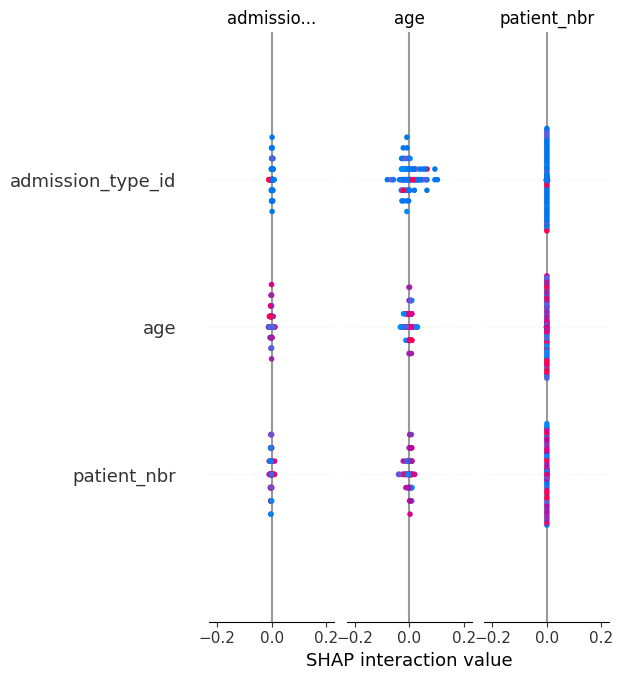

In [59]:
import shap
import numpy as np

# Ensure that the shapes are correct
print(f"Shape of train_features_array: {train_features_array.shape}")
print(f"Shape of test_features_array: {test_features_array.shape}")

# Initialize SHAP KernelExplainer with the model's prediction function
explainer = shap.KernelExplainer(model, train_features_array[:100])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(test_features_array[:100])
# Ensure the shapes of shap_values and test_features_array are compatible
print(f"Shape of shap_values: {shap_values.shape}")

# Select a slice of test_features_array (e.g., the first 100 samples)
slice_indices = slice(0, 100)  # Adjust indices as needed
test_features_slice = test_features_array[slice_indices]

# Plot the SHAP summary plot for the selected slice
shap.summary_plot(shap_values[slice_indices], test_features_slice, feature_names=features_names)


<Figure size 1000x800 with 0 Axes>

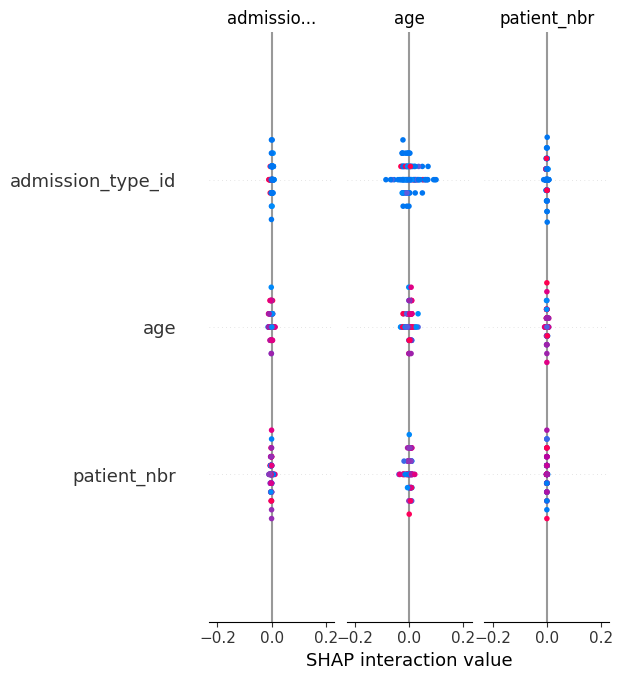

In [57]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 8))  # Adjust dimensions as needed

# Plot the SHAP summary plot

shap.summary_plot(shap_values, test_features_array[:100], feature_names=features_names,plot_type="bar")
